Сначала подключим все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.decomposition import PCA

# Загружаем датасет
data = pd.read_csv('lizard_data.csv', delimiter=';')

data.head()
#data.info()

,Species_num,Sex_num,Sex,MBS,VSN,CSN,GSN,FPNr,SDLr,SCSr,...,SVL,TRL,HL,PL,ESD,HW,HH,MO,FFL,HFL
0,1,1,M,54,22,10,25,18,27,6,...,52.8,25.8,18.0,12.8,6.2,7.9,4.8,10.5,17.2,31.5
1,1,1,M,49,25,12,24,17,25,9,...,62.0,29.0,21.1,14.0,7.2,9.1,5.1,10.2,20.0,33.0
2,1,1,M,50,25,9,25,19,27,6,...,60.0,29.5,19.9,13.9,7.5,8.6,4.9,11.0,19.9,34.0
3,1,1,M,49,24,11,21,20,25,5,...,61.5,29.8,21.5,14.8,7.2,9.8,4.8,11.1,19.5,33.2
4,1,1,M,50,22,9,26,19,25,5,...,56.0,27.2,19.2,16.0,7.8,8.6,4.9,10.5,19.2,34.2


**1. Критерий, позволяющий наилучшим возможным образом отличать ящериц
вида №5 от всех остальных ящериц и использующий только количество бедренных пор
справа (FPNr).**  
Подсказка: постройте и изучите распределение ящериц по FPNr в зависимости от их
вида.


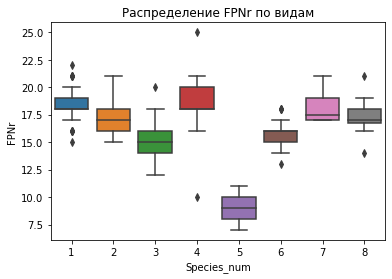

In [2]:
# Построим график распределения FPNr в зависимости от вида
sns.boxplot(x='Species_num', y='FPNr', data=data)
plt.title('Распределение FPNr по видам')
plt.show()


In [3]:
# Визуально осмотрим график и выберем пороговое значение для FPNr

h = 11.5 

# Определим простую критериальную функцию
def criterion_species_5(FPNr, threshold):
    return '5' if FPNr < threshold else 'Other'

# Применим критерий и оценим его эффективность
data['predicted_species'] = data['FPNr'].apply(criterion_species_5, threshold=h)

In [4]:
# Вычислим матрицу ошибок и точность
cm = confusion_matrix(data['Species_num'].apply(lambda x: '5' if x == 5 else 'Other'), data['predicted_species'])
print("Матрица ошибок:\n", cm)
accuracy = accuracy_score(data['Species_num'].apply(lambda x: '5' if x == 5 else 'Other'), data['predicted_species'])
print("Точность:", accuracy)

Матрица ошибок:
 [[ 24   0]
 [  1 539]]
Точность: 0.99822695035461


In [5]:
# Удалим столбец predicted_species
data = data.drop('predicted_species', axis = 1)

**2. Создайте критерий, позволяющий наилучшим возможным образом отличать ящериц
вида №5 от всех остальных ящериц и использующий две переменных из измеряемых
морфометрических и фолидозных признаков.**  
Подсказка: одним из способов нахождения наилучшей пары предсказывающих
переменных (предикторов) может быть перебор всех возможных пар переменных.


In [8]:
# Функция, которая считает точность каждого критерия
def calculate_accuracy_v(data, feature, threshold, target_value):
    predicted_values = data[feature] < threshold
    true_values = data['Species_num'] == target_value
    accuracy = (predicted_values == true_values).mean()
    return accuracy

features = data.columns[3:]  # Выбираем столбцы с морфологическими признаками и признаками фоллидоза

best_mean_accuracy = 0
best_pair = None
best_thresholds = (None, None)

# Итерация через все возможные пары переменных и выбор наилучшей
for f1, f2 in combinations(features, 2):
    thresholds = {}
    for feature in [f1, f2]:
        accuracies = [calculate_accuracy_v(data, feature, threshold, 5) for threshold in data[feature].unique()]
        best_index = np.argmax(accuracies)
        best_threshold = data[feature].unique()[best_index]
        thresholds[feature] = best_threshold

    accuracy_f1 = calculate_accuracy_v(data, f1, thresholds[f1], 5)
    accuracy_f2 = calculate_accuracy_v(data, f2, thresholds[f2], 5)
    mean_accuracy = (accuracy_f1 + accuracy_f2) / 2

    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_pair = (f1, f2)
        best_thresholds = (thresholds[f1], thresholds[f2])

print("Лучшая пара признаков:", best_pair)
print("Лучшие пороги значений:", best_thresholds)
print("Лучшая средняя точность:", best_mean_accuracy)

print(f"Для вида 5: {best_pair[0]} < {best_thresholds[0]} и {best_pair[1]} < {best_thresholds[1]}")

Лучшая пара признаков: ('MBS', 'FPNr')
Лучшие пороги значений: (40, 12)
Лучшая средняя точность: 0.9937943262411348
Для вида 5: MBS < 40 и FPNr < 12


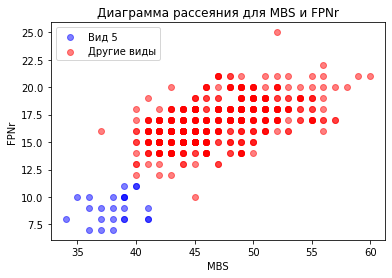

In [9]:
# Фильтруем данные для вида 5 и остальных
species_5 = data[data['Species_num'] == 5]
other_species = data[data['Species_num'] != 5]

# Строим диаграмму рассеяния
plt.scatter(species_5[best_pair[0]], species_5[best_pair[1]], label='Вид 5', c='blue', alpha=0.5)
plt.scatter(other_species[best_pair[0]], other_species[best_pair[1]], label='Другие виды', c='red', alpha=0.5)


plt.xlabel(best_pair[0])
plt.ylabel(best_pair[1])
plt.title(f'Диаграмма рассеяния для {best_pair[0]} и {best_pair[1]}')
plt.legend()

# Отобразим график
plt.show()

In [10]:
# Выберем пороговые значения для FPNr и MBS

fpnr_value = 12
mbs_value = 40

# Определим простую критериальную функцию
def criterion_species_5_2(FPNr, MBS, fpnr_value, mbs_value):
    return '5' if  FPNr < fpnr_value and MBS < mbs_value else 'Other'

# Применим критерий и оценим его эффективность
data['predicted_species'] = data.apply(lambda row: criterion_species_5_2(row['FPNr'], row['MBS'], fpnr_value, mbs_value), axis=1)

In [11]:
# Вычислим матрицу ошибок и точность
cm = confusion_matrix(data['Species_num'].apply(lambda x: '5' if x == 5 else 'Other'), data['predicted_species'])
print("Матрица ошибок:\n", cm)
accuracy = accuracy_score(data['Species_num'].apply(lambda x: '5' if x == 5 else 'Other'), data['predicted_species'])
print("Точность:", accuracy)

Матрица ошибок:
 [[ 19   5]
 [  0 540]]
Точность: 0.9911347517730497


In [12]:
# Удалим столбец predicted_species
data = data.drop('predicted_species', axis = 1)

**3. Создайте критерий, позволяющий наилучшим возможным образом предсказывать пол
ящериц вне зависимости от их вида по морфометрическим признакам и/или признакам
фолидоза.**  
Подсказка от биологов: предполагается (но не гарантируется!), что пол будет
взаимосвязан с отношениями некоторых измеряемых длин; но это не исключает
участия в критерии и других предикторов.


In [13]:
# Определим минимальное и максимальное количество признаков
min_features = 2
max_features = 4

best_accuracy = 0
best_combination = None
best_tree = None

# Проитерируемся по всем возможным комбинациям признаков
for n_features in range(min_features, max_features + 1):
    for feature_combination in combinations(features, n_features):
        X = data[list(feature_combination)]
        y = data['Sex_num']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Тренируем дерево решений с max_depth = 3
        tree = DecisionTreeClassifier(max_depth=3, random_state=42)
        tree.fit(X_train, y_train)

        # Оценим производительность
        y_pred = tree.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = feature_combination
            best_tree = tree

print("Лучшая комбинация признаков:", best_combination)
print("Лучшая точность на тестовой выборке:", best_accuracy)

# Визуализируем дерево решений
print(export_text(best_tree, feature_names=list(best_combination)))

Лучшая комбинация признаков: ('VSN', 'HL', 'PL', 'MO')
Лучшая точность на тестовой выборке: 0.8529411764705882
|--- VSN <= 24.50
|   |--- MO <= 8.45
|   |   |--- VSN <= 23.50
|   |   |   |--- class: 1
|   |   |--- VSN >  23.50
|   |   |   |--- class: 2
|   |--- MO >  8.45
|   |   |--- PL <= 12.15
|   |   |   |--- class: 1
|   |   |--- PL >  12.15
|   |   |   |--- class: 1
|--- VSN >  24.50
|   |--- VSN <= 25.50
|   |   |--- PL <= 12.15
|   |   |   |--- class: 2
|   |   |--- PL >  12.15
|   |   |   |--- class: 1
|   |--- VSN >  25.50
|   |   |--- HL <= 21.75
|   |   |   |--- class: 2
|   |   |--- HL >  21.75
|   |   |   |--- class: 1



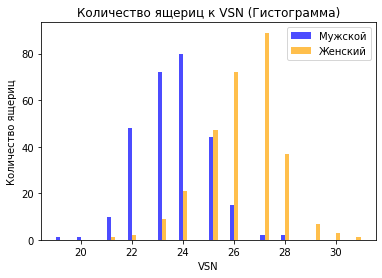

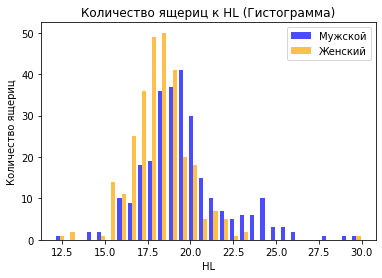

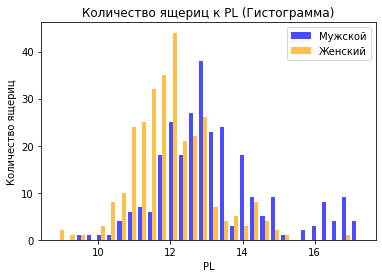

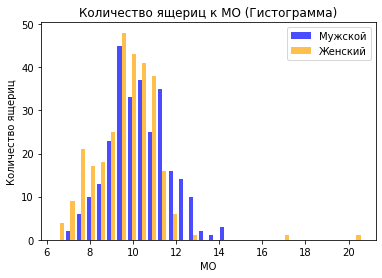

In [14]:
# Итерируемся по каждому из лучших признаков
for feature in best_combination:
    fig, ax = plt.subplots()

    # Разделяем данные для мужского и женского пола
    male_data = data[data['Sex_num'] == 1][feature]
    female_data = data[data['Sex_num'] == 2][feature]

    # Строим гистограммы
    ax.hist([male_data, female_data], bins=30, color=['blue', 'orange'], label=['Мужской', 'Женский'], alpha=0.7)

    
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество ящериц')
    ax.set_title(f'Количество ящериц к {feature} (Гистограмма)')

    ax.legend()

    # Отобразим график
    plt.show()

In [15]:
# Определим простую критериальную функцию
def criterion_sex(VSN, HL, PL, MO):
    return '2' if  (VSN <= 24.5 and MO <= 8.45 and VSN > 23.5) or (VSN == 25 and PL <= 12.15) or (VSN > 25.5 and HL <= 21.75) else '1'

# Применим критерий и оценим его эффективность
data['predicted_sex'] = data.apply(lambda row: criterion_sex(row['VSN'], row['MO'], row['PL'], row['HL']), axis=1)

In [16]:
# Вычислим матрицу ошибок и точность
cm = confusion_matrix(data['Sex_num'].apply(lambda x: '2' if x == 2 else '1'), data['predicted_sex'])
print("Матрица ошибок:\n", cm)
accuracy = accuracy_score(data['Sex_num'].apply(lambda x: '2' if x == 2 else '1'), data['predicted_sex'])
print("Точность на всей выборке:", accuracy)

Матрица ошибок:
 [[250  25]
 [ 50 239]]
Точность на всей выборке: 0.8670212765957447


In [17]:
# Удалим столбец predicted_species
data = data.drop('predicted_sex', axis = 1)

**4. Набор критериев,позволяющих наилучшим возможным образом отличать друг от друга все виды внутри
следующих групп:  
a) виды №6 и №7,  
b) виды №1 и №2,  
c) виды №3, №4 и №5.**


In [18]:
# Выбираем столбцы с морфологическими признаками и признаками фоллидоза
features = data.columns[3:]

def best_pair_for_group(data, species_group):
    data_group = data[data['Species_num'].isin(species_group)]
    best_accuracy = 0
    best_pair = None
    best_tree = None

    for f1, f2, f3 in combinations(features, 3):
        X = data_group[[f1, f2, f3]]
        y = data_group['Species_num']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        tree = DecisionTreeClassifier(max_depth=3, random_state=42)
        tree.fit(X_train, y_train)

        y_pred = tree.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_pair = (f1, f2, f3)
            best_tree = tree

    return best_pair, best_accuracy, best_tree

# Определим группы видов
species_groups = [
    ('Группа A', [6, 7]),
    ('Группа B', [1, 2]),
    ('Группа C', [3, 4, 5])
]

a) виды № 6 и № 7

Лучший набор признаков для Группа A: ('VSN', 'GSN', 'FPNr')
Лучшая точность тестовой выборки для Группа A: 1.0
Дерево решений для Группа A:
|--- GSN <= 25.50
|   |--- FPNr <= 18.50
|   |   |--- GSN <= 24.50
|   |   |   |--- class: 6
|   |   |--- GSN >  24.50
|   |   |   |--- class: 6
|   |--- FPNr >  18.50
|   |   |--- class: 7
|--- GSN >  25.50
|   |--- FPNr <= 16.00
|   |   |--- class: 6
|   |--- FPNr >  16.00
|   |   |--- GSN <= 26.50
|   |   |   |--- class: 7
|   |   |--- GSN >  26.50
|   |   |   |--- class: 7



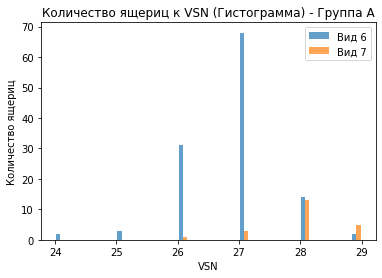

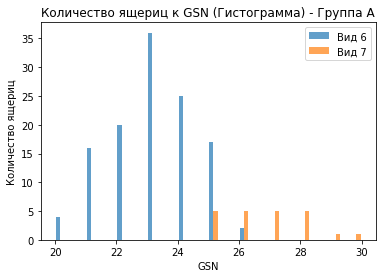

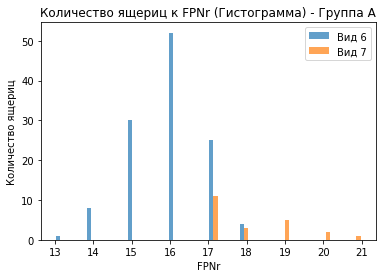

In [19]:
group_name, species_group = species_groups[0]

best_pair, best_accuracy, best_tree = best_pair_for_group(data, species_group)
print(f"Лучший набор признаков для {group_name}:", best_pair)
print(f"Лучшая точность тестовой выборки для {group_name}:", best_accuracy)

# Визуализируем дерево решений
print(f"Дерево решений для {group_name}:")
print(export_text(best_tree, feature_names=list(best_pair)))
    

# Проитерируемся через каждый признак в best_pair
for feature in best_pair:
    fig, ax = plt.subplots()

    # Разделим данные для каждого вида в группе
    group_data = [data[data['Species_num'] == species][feature] for species in species_group]

    # Построим гистограммы для каждого вида
    ax.hist(group_data, bins=30, alpha=0.7, label=[f'Вид {i}' for i in species_group])

    # Добавим названия и метки
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество ящериц')
    ax.set_title(f'Количество ящериц к {feature} (Гистограмма) - {group_name}')

    ax.legend()

    # Отобразим графики
    plt.show()

In [21]:
# Определим простую критериальную функцию
def criterion_species_5_4_1(GSN, VSN, FPNr):
    return '6' if (GSN <= 25.5 and FPNr <= 18.5) or (GSN > 25.5 and FPNr <= 16)  else '7'

# Применим критерий и оценим его эффективность
data_group = data[data['Species_num'].isin(species_group)]
data_group.loc[:, 'predicted_species'] = data_group.apply(lambda row: criterion_species_5_4_1(row['GSN'], row['VSN'], row['FPNr']), axis=1)

In [22]:
# Вычислим матрицу ошибок и точность
cm = confusion_matrix(data_group['Species_num'].apply(lambda x: '6' if x == 6 else '7'), data_group['predicted_species'])
print("Матрица ошибок:\n", cm)
accuracy = accuracy_score(data_group['Species_num'].apply(lambda x: '6' if x == 6 else '7'), data_group['predicted_species'])
print("Точность:", accuracy)

Матрица ошибок:
 [[119   1]
 [  3  19]]
Точность: 0.971830985915493


In [23]:
# Удалим столбец predicted_species
data_group = data_group.drop('predicted_species', axis = 1)

b) виды № 1 и № 2

Лучший набор признаков для Группа B: ('VSN', 'MTr', 'HL')
Лучшая точность тестовой выборки для Группа B: 0.9743589743589743
Дерево решений для Группа B:
|--- MTr <= 2.50
|   |--- HL <= 19.85
|   |   |--- VSN <= 25.50
|   |   |   |--- class: 2
|   |   |--- VSN >  25.50
|   |   |   |--- class: 2
|   |--- HL >  19.85
|   |   |--- VSN <= 21.50
|   |   |   |--- class: 2
|   |   |--- VSN >  21.50
|   |   |   |--- class: 1
|--- MTr >  2.50
|   |--- HL <= 18.65
|   |   |--- MTr <= 3.50
|   |   |   |--- class: 2
|   |   |--- MTr >  3.50
|   |   |   |--- class: 1
|   |--- HL >  18.65
|   |   |--- class: 1



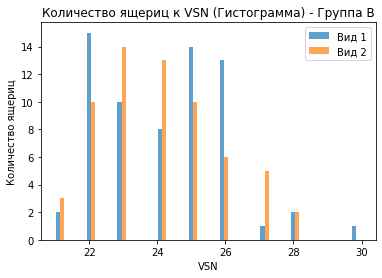

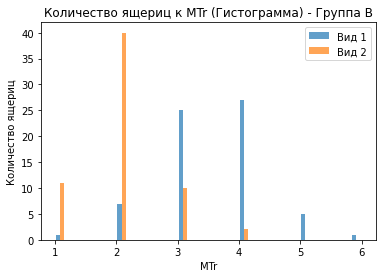

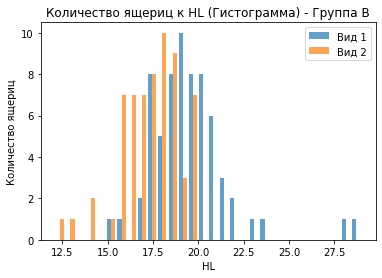

In [24]:
group_name, species_group = species_groups[1]

best_pair, best_accuracy, best_tree = best_pair_for_group(data, species_group)
print(f"Лучший набор признаков для {group_name}:", best_pair)
print(f"Лучшая точность тестовой выборки для {group_name}:", best_accuracy)

# Визуализируем дерево решений
print(f"Дерево решений для {group_name}:")
print(export_text(best_tree, feature_names=list(best_pair)))
    

# Проитерируемся через каждый признак в best_pair
for feature in best_pair:
    fig, ax = plt.subplots()

    # Разделим данные для каждого вида в группе
    group_data = [data[data['Species_num'] == species][feature] for species in species_group]

    # Построим гистограммы для каждого вида
    ax.hist(group_data, bins=30, alpha=0.7, label=[f'Вид {i}' for i in species_group])

    # Добавим названия и метки
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество ящериц')
    ax.set_title(f'Количество ящериц к {feature} (Гистограмма) - {group_name}')

    ax.legend()

    # Отобразим график
    plt.show()

In [26]:
# Определим простую критериальную функцию
def criterion_species_5_4_2(MTr, HL, VSN):
    return '2' if (MTr <= 2.5 and HL <= 19.85) or (MTr <= 2.5 and HL > 19.85 and VSN <= 21.5) or (MTr == 3 and HL <= 18.65) else '1'

# Применим критерий и оценим его эффективность
data_group = data[data['Species_num'].isin(species_group)]
data_group.loc[:, 'predicted_species'] = data_group.apply(lambda row: criterion_species_5_4_2(row['MTr'], row['HL'], row['VSN']), axis=1)

In [27]:
# Вычислим матрицу ошибок и точность
cm = confusion_matrix(data_group['Species_num'].apply(lambda x: '2' if x == 2 else '1'), data_group['predicted_species'])
print("Матрица ошибок:\n", cm)
accuracy = accuracy_score(data_group['Species_num'].apply(lambda x: '2' if x == 2 else '1'), data_group['predicted_species'])
print("Точность:", accuracy)

Матрица ошибок:
 [[58  8]
 [ 2 61]]
Точность: 0.9224806201550387


In [28]:
# Удалим столбец predicted_species
data_group = data_group.drop('predicted_species', axis = 1)

c) виды № 3, № 4, и № 5

Лучший набор признаков для Группа C: ('CSN', 'FPNr', 'SCGr')
Лучшая точность тестовой выборки для Группа C: 0.9878048780487805
Дерево решений для Группа C:
|--- FPNr <= 17.50
|   |--- FPNr <= 11.50
|   |   |--- CSN <= 9.50
|   |   |   |--- class: 5
|   |   |--- CSN >  9.50
|   |   |   |--- class: 4
|   |--- FPNr >  11.50
|   |   |--- SCGr <= 3.50
|   |   |   |--- class: 4
|   |   |--- SCGr >  3.50
|   |   |   |--- class: 3
|--- FPNr >  17.50
|   |--- SCGr <= 8.50
|   |   |--- CSN <= 7.50
|   |   |   |--- class: 3
|   |   |--- CSN >  7.50
|   |   |   |--- class: 4
|   |--- SCGr >  8.50
|   |   |--- CSN <= 9.50
|   |   |   |--- class: 3
|   |   |--- CSN >  9.50
|   |   |   |--- class: 4



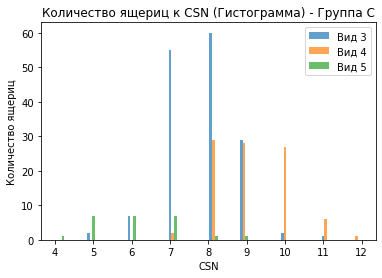

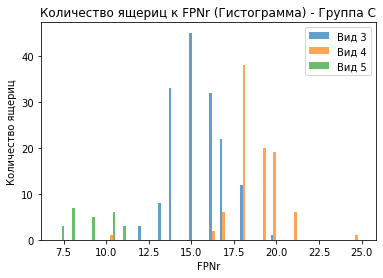

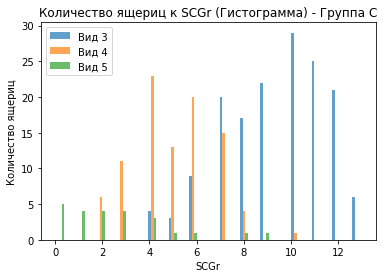

In [29]:
group_name, species_group = species_groups[2]

best_pair, best_accuracy, best_tree = best_pair_for_group(data, species_group)
print(f"Лучший набор признаков для {group_name}:", best_pair)
print(f"Лучшая точность тестовой выборки для {group_name}:", best_accuracy)

# Визуализируем дерево решений
print(f"Дерево решений для {group_name}:")
print(export_text(best_tree, feature_names=list(best_pair)))
    

# Проитерируемся через каждый признак в best_pair
for feature in best_pair:
    fig, ax = plt.subplots()

    # Разделим данные для каждого вида в группе
    group_data = [data[data['Species_num'] == species][feature] for species in species_group]

    # Построим гистограммы для каждого вида
    ax.hist(group_data, bins=30, alpha=0.7, label=[f'Вид {i}' for i in species_group])

    # Добавим названия и метки
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество ящериц')
    ax.set_title(f'Количество ящериц к {feature} (Гистограмма) - {group_name}')

    ax.legend()

    # Отобразим график
    plt.show()

In [31]:
# Определим простую критериальную функцию
def criterion_species_5_4_3(FPNr, SCGr, CSN):
    if (FPNr <= 17.5 and FPNr > 11.5 and SCGr > 3.5) or (FPNr > 17.5 and SCGr > 8.5 and CSN <= 9.5) or (FPNr > 17.5 and SCGr <= 8.5 and CSN <= 7.5):
        return '3'
    if (FPNr <= 11.5 and CSN <= 9.5):
        return '5'
    else:
        return '4'

# Применим критерий и оценим его эффективность
data_group = data[data['Species_num'].isin(species_group)]
data_group.loc[:, 'predicted_species'] = data_group.apply(lambda row: criterion_species_5_4_3(row['FPNr'], row['SCGr'], row['CSN']), axis=1)

In [32]:
# Вычислим матрицу ошибок и точность
cm = confusion_matrix(data_group['Species_num'].apply(lambda x: '3' if x == 3 else '4' if x == 4 else '5'), data_group['predicted_species'])
print("Матрица ошибок:\n", cm)
accuracy = accuracy_score(data_group['Species_num'].apply(lambda x: '3' if x == 3 else '4' if x == 4 else '5'), data_group['predicted_species'])
print("Точность:", accuracy)

Матрица ошибок:
 [[155   1   0]
 [  4  89   0]
 [  0   0  24]]
Точность: 0.9816849816849816


In [33]:
# Удалим столбец predicted_species
data_group = data_group.drop('predicted_species', axis = 1)

**5. Критерий или набор критериев, позволяющий наилучшим возможным
образом предсказывать вид или вид и пол ящериц во всей их совокупности (это может
понадобиться биологам, если они не знают место отлова ящерицы).**


In [34]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

# Подготовим данные, объединив целевые переменные (пол и видовой состав) в один столбец.
data['Sex_Species'] = data['Sex_num'].astype(str) + "_" + data['Species_num'].astype(str)

features = data.columns[3:-1]  # Выберем столбцы с морфологическими признаками и признаками фоллидоза
X = data[features]
y = data['Sex_Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Применим PCA для уменьшения размерности
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Создайте дерево решений
tree = DecisionTreeClassifier(random_state=42)

# Определим сетку гиперпараметров для поиска
param_grid = {
    'max_depth': range(2, 11),
    'min_samples_split': range(2, 11)
}

# Создадим объект GridSearchCV с 5-кратной кросс-валидацией
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Получим лучшие гиперпараметры и подготовим наилучшее дерево решений
best_params = grid_search.best_params_
best_tree = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)
best_tree.fit(X_train_pca, y_train)

# Оценим производительность с помощью кросс-валидации
cv_scores = cross_val_score(best_tree, X_train_pca, y_train, cv=5)

# Протестируем наилучшее дерево решений на тестовом наборе
#y_pred = best_tree.predict(X_test_pca)
#accuracy = accuracy_score(y_test, y_pred)
#conf_matrix = confusion_matrix(y_test, y_pred)
#report = classification_report(y_test, y_pred)

#print("Best hyperparameters:", best_params)
#print("Cross-validation scores:", cv_scores)
#print("Mean cross-validation score:", cv_scores.mean())
#print("Accuracy on the test set:", accuracy)
#print("\nConfusion Matrix:\n", conf_matrix)
#print("\nClassification Report:\n", report)

In [35]:
best_tree.fit(X, y)

y_pred = best_tree.predict(X)
accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred)

print("\nТочность на всем датасете:", accuracy)
print("\nМатрица ошибок на всем датасете:\n", conf_matrix)
print("\nОтчет о классификации по всему набору данных:\n", report)


Точность на всем датасете: 0.9326241134751773

Матрица ошибок на всем датасете:
 [[ 39   2   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0  43   1   0   0   0   1   0   1   0   0   0   0   0]
 [  0   0 112   0   0   1   0   0   1   0   0   0   0   0]
 [  0   0   0  48   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  10   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0  14   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   4  18   0   1   0   0   0   0   0]
 [  0   3   0   0   0   1   0  13   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0  40   0   0   0   0   0]
 [  0   3   1   1   0   1   0   0   2  37   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0  11   1   0   0]
 [  0   0   2   0   0   1   0   0   0   0   0 117   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  22   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   2]]

Отчет о классификации по всему набору данных:
               precision    recall  f1-score

In [36]:
# Визуализируем дерево решений
print(f"Дерево решений:")
print(export_text(best_tree, feature_names=list(features)))

Дерево решений:
|--- VSN <= 25.50
|   |--- ESD <= 7.65
|   |   |--- MBS <= 46.50
|   |   |   |--- FPNr <= 11.50
|   |   |   |   |--- VSN <= 22.50
|   |   |   |   |   |--- class: 1_5
|   |   |   |   |--- VSN >  22.50
|   |   |   |   |   |--- class: 2_5
|   |   |   |--- FPNr >  11.50
|   |   |   |   |--- MO <= 10.22
|   |   |   |   |   |--- MO <= 7.95
|   |   |   |   |   |   |--- HH <= 4.65
|   |   |   |   |   |   |   |--- class: 1_3
|   |   |   |   |   |   |--- HH >  4.65
|   |   |   |   |   |   |   |--- class: 2_3
|   |   |   |   |   |--- MO >  7.95
|   |   |   |   |   |   |--- TRL <= 29.80
|   |   |   |   |   |   |   |--- class: 1_3
|   |   |   |   |   |   |--- TRL >  29.80
|   |   |   |   |   |   |   |--- class: 2_3
|   |   |   |   |--- MO >  10.22
|   |   |   |   |   |--- class: 1_8
|   |   |--- MBS >  46.50
|   |   |   |--- FFL <= 18.85
|   |   |   |   |--- MTr <= 2.50
|   |   |   |   |   |--- HW <= 7.05
|   |   |   |   |   |   |--- MBS <= 49.50
|   |   |   |   |   |   |   |--- cla

In [37]:
# Удалим столбец Sex_Species
data = data.drop('Sex_Species', axis = 1)